# Final Project
Tackling Long-Tail Distribution Problem

## 0. Base Setting

In [1]:
import torch, torchvision
import torch.nn as nn

## 1. Dataset Load

In [2]:
torch.manual_seed(42)

In [3]:
from data.dataset import get_dataloader

train_loader, test_loader, cls_num_list = get_dataloader(mode = "unbalanced")

Files already downloaded and verified


In [4]:
import torch.nn.functional as F

class NormalizedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormalizedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        x_norm = F.normalize(x, p=2, dim=1)
        w_norm = F.normalize(self.weight, p=2, dim=1)
        return F.linear(x_norm, w_norm)

In [5]:
class CifarResNet18(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(CifarResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        from torchvision.models import resnet18
        self.backbone = resnet18(pretrained=False, num_classes=num_classes)
        self.backbone.conv1 = self.conv1
        self.backbone.bn1 = self.bn1
        self.backbone.relu = self.relu
        self.backbone.maxpool = nn.Identity()  # Remove maxpool layer
        
        in_features = self.backbone.fc.in_features
        if use_norm:
            self.backbone.fc = NormalizedLinear(in_features, num_classes)
        else:
            self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x
    
model = CifarResNet18(use_norm = True)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

CifarResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(

d:\code\DeepLearningLab\project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\code\DeepLearningLab\project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
import math

warmup_epochs = 5
epochs = 90

# LDAM 용 cosine annealing 함수 제작
def cosine_annealing(epoch):
    if epoch < warmup_epochs:
        return float(epoch+1) / float(warmup_epochs)
    else:
        progress = float(epoch - warmup_epochs) / float(max(1, epochs - warmup_epochs))
        scale = 0.5 * (1.0 + math.cos(math.pi * progress))
        return scale

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
from losses.loss import myLoss

learning_rate = 0.1
momentum = 0.9
weight_decay = 5e-4

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay=weight_decay)
criterion = myLoss(mode="LDAM", cls_num_list=cls_num_list)
scheduler = LambdaLR(optimizer, lr_lambda=cosine_annealing)
# scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 1 - (epoch/epochs))

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(device)

cuda:0


In [9]:
def test_loss_cal(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    count = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            count += 1
    test_loss = test_loss / count
    model.train()
    return test_loss

In [10]:
import os
os.makedirs('./models', exist_ok=True)

train_losses = list()
test_losses = list()

model_save_path = "./models/LDAM_unbalanced.pth"
best_loss = float('inf')

model.train()
interval = max(1, len(train_loader) // 5)
for epoch in range(epochs):
    total_loss = 0.0
    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    test_loss = test_loss_cal(model, test_loader, criterion, device)
    print(f"[epoch {epoch+1}] train_loss: {total_loss/len(train_loader):.4f}, test_loss: {test_loss:.4f}")
    train_losses.append(total_loss/len(train_loader))
    test_losses.append(test_loss)
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), model_save_path)
        print("[Best Model Saved!]")

[epoch 1] train_loss: 14.1895, test_loss: 14.8084
[Best Model Saved!]
[epoch 2] train_loss: 13.6438, test_loss: 14.4235
[Best Model Saved!]
[epoch 3] train_loss: 13.3627, test_loss: 14.0629
[Best Model Saved!]
[epoch 4] train_loss: 13.0794, test_loss: 13.7298
[Best Model Saved!]
[epoch 5] train_loss: 12.8277, test_loss: 13.6344
[Best Model Saved!]
[epoch 6] train_loss: 12.5640, test_loss: 13.2464
[Best Model Saved!]
[epoch 7] train_loss: 12.2878, test_loss: 13.1104
[Best Model Saved!]
[epoch 8] train_loss: 12.0891, test_loss: 12.9207
[Best Model Saved!]
[epoch 9] train_loss: 11.8664, test_loss: 12.8953
[Best Model Saved!]
[epoch 10] train_loss: 11.6705, test_loss: 12.4714
[Best Model Saved!]
[epoch 11] train_loss: 11.4598, test_loss: 12.3811
[Best Model Saved!]
[epoch 12] train_loss: 11.2744, test_loss: 12.5120
[epoch 13] train_loss: 11.1041, test_loss: 12.1200
[Best Model Saved!]
[epoch 14] train_loss: 10.9334, test_loss: 12.1347
[epoch 15] train_loss: 10.7833, test_loss: 11.6912
[Bes

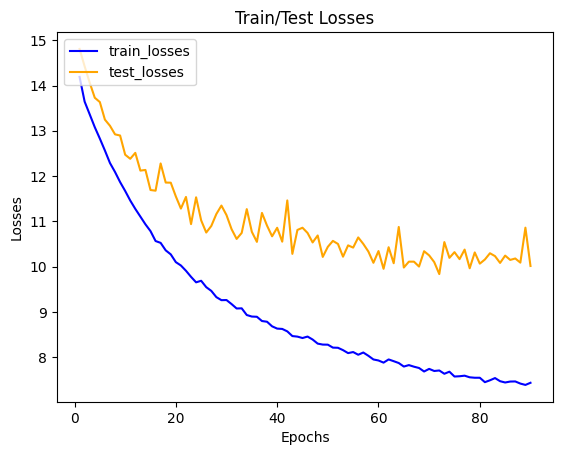

In [11]:
import matplotlib.pyplot as plt

X = [i+1 for i in range(len(train_losses))]

plt.plot(X, train_losses, color="blue", label = "train_losses")
plt.plot(X, test_losses, color="orange", label = "test_losses")

plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(loc="upper left")
plt.title("Train/Test Losses")

plt.show()

In [12]:
from metrics.metric import *

model_t = CifarResNet18(use_norm = True);     t_save_path = "./models/LDAM_unbalanced.pth"
model_v = CifarResNet18();     v_save_path = "./models/BASE_balanced.pth"
model_b = CifarResNet18(use_norm = True);     b_save_path = "./models/LDAM_balanced.pth"

model_t.load_state_dict(torch.load(t_save_path))
model_v.load_state_dict(torch.load(v_save_path))
model_b.load_state_dict(torch.load(b_save_path))
model_t = model_t.to(device);   model_v = model_v.to(device);   model_b = model_b.to(device)

top_1_acc = top_1_metric(model_t, test_loader, device)
relative_acc = relative_accuracy(model_t, model_v, model_b, test_loader, device)
print(f"[Top-1 Accuracy] {top_1_acc:.4f}, [Relative Accuracy] {relative_acc:.4f}")

d:\code\DeepLearningLab\project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\code\DeepLearningLab\project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\sttar\AppData\Local\Temp\ipykernel_25304\2848195419.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `we

[Top-1 Accuracy] 54.4000, [Relative Accuracy] 0.8586


In [13]:
(_, head_test), (_, mid_test), (_, tail_test) = get_dataloader(split=True)
head_acc = top_1_metric(model_b, head_test, device)
mid_acc = top_1_metric(model_b, mid_test, device)
tail_acc = top_1_metric(model_b, tail_test, device)
print(f"[Head Accuracy] {head_acc:.4f}, [Mid Accuracy] {mid_acc:.4f}, [Tail Accuracy] {tail_acc:.4f}")

Files already downloaded and verified
[Head Accuracy] 57.1176, [Mid Accuracy] 56.6061, [Tail Accuracy] 60.1818


In [14]:
from metrics.metric import *

v_acc = top_1_metric(model_b, test_loader, device)
print(v_acc)

57.96
